# GeneratingMockData1
*David Thomas 2017/01/18*

### Model
For each halo in a fixed 1600 arcmin^2 field of view from the Millennium Simulation catalog we sample from the conditional luminosity distribution and then apply Gaussian noise with variance $\sigma_L$. The result is a pandas dataframe with columns: 'gal_id', 'ra', 'dec', 'z', 'mass_h', 'lum_true', 'lum_obs'. The PGM for our distribution is rendered below.

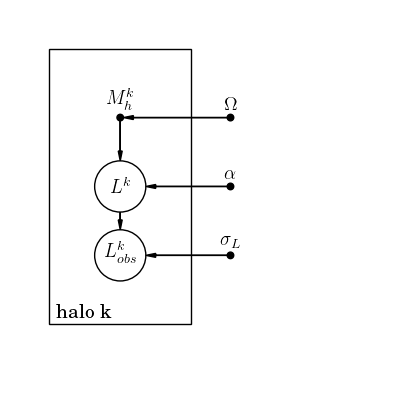

In [7]:
%matplotlib inline

from matplotlib import rc
rc("font", family="serif", size=14)
rc("text", usetex=True)

import daft

pgm = daft.PGM([5, 5], origin=[0, 0])

#dimensions
plate_x = 0.5
plate_y = 1
plate_width = 1.8
plate_height = 3.5
plate_x_center = plate_x + (plate_width / 2.0)
plate_y_fourth = plate_height / 4.0
scale = 1.3

#plate
pgm.add_plate(daft.Plate([plate_x, plate_y, plate_width, plate_height], label="halo k"))

#nodes
pgm.add_node(daft.Node("m_h", "$M_h^k$", plate_x_center, plate_y + 3 * plate_y_fourth, fixed=True))
pgm.add_node(daft.Node("l", "$L^k$", plate_x_center, plate_y + 2 * plate_y_fourth, scale=scale))
pgm.add_node(daft.Node("l_obs", "$L^k_{obs}$", plate_x_center, plate_y + 1 * plate_y_fourth, scale=scale))

pgm.add_node(daft.Node("sigma_l", "$\sigma_L$", 2*plate_x_center, plate_y + 1 * plate_y_fourth, fixed=True))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 2*plate_x_center, plate_y + 2 * plate_y_fourth, fixed=True))
pgm.add_node(daft.Node("omega", r"$\Omega$", 2*plate_x_center, plate_y + 3 * plate_y_fourth, fixed=True))

#edges
pgm.add_edge("m_h", "l")
pgm.add_edge("l", "l_obs")
pgm.add_edge("sigma_l", "l_obs")
pgm.add_edge("alpha", "l")
pgm.add_edge("omega", "m_h")

pgm.render()

In [143]:
import pandas as pd
from massinference.angle import Angle

# opening, white-listing, renaming
usecols = ['GalID', 'pos_0[rad]', 'pos_1[rad]', 'M_Subhalo[M_sol/h]', 'z_spec']
guo = pd.read_table(
    '/Users/user/Code/Pangloss/data/GGL_los_8_0_0_0_0_N_4096_ang_4_Guo_galaxies_on_plane_27_to_63.images.txt', 
    usecols=usecols)
print guo.columns
guo.rename(
    columns={'GalID': 'gal_id',
             'M_Subhalo[M_sol/h]': 'mass_h',
             'z_spec': 'z'
            }, 
    inplace=True)

# convert to arcmin
guo['ra'] = Angle.radian_to_arcmin(guo['pos_0[rad]'])
guo['dec'] = Angle.radian_to_arcmin(guo['pos_1[rad]'])

# field of view bounds
ra_i = guo['ra'].min()
dec_i = guo['dec'].min()
ra_f = ra_i + 40
dec_f = dec_i + 40

# clip data, fov = field of view
fov = guo[(guo['ra'] >= ra_i)
           & (guo['ra'] < ra_f)
           & (guo['dec'] >= dec_i)
           & (guo['dec'] < dec_f)]

Index([u'GalID', u'z_spec', u'pos_0[rad]', u'pos_1[rad]',
       u'M_Subhalo[M_sol/h]'],
      dtype='object')


In the next cell we plot the most massive objects in the field of view from a few angles.

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


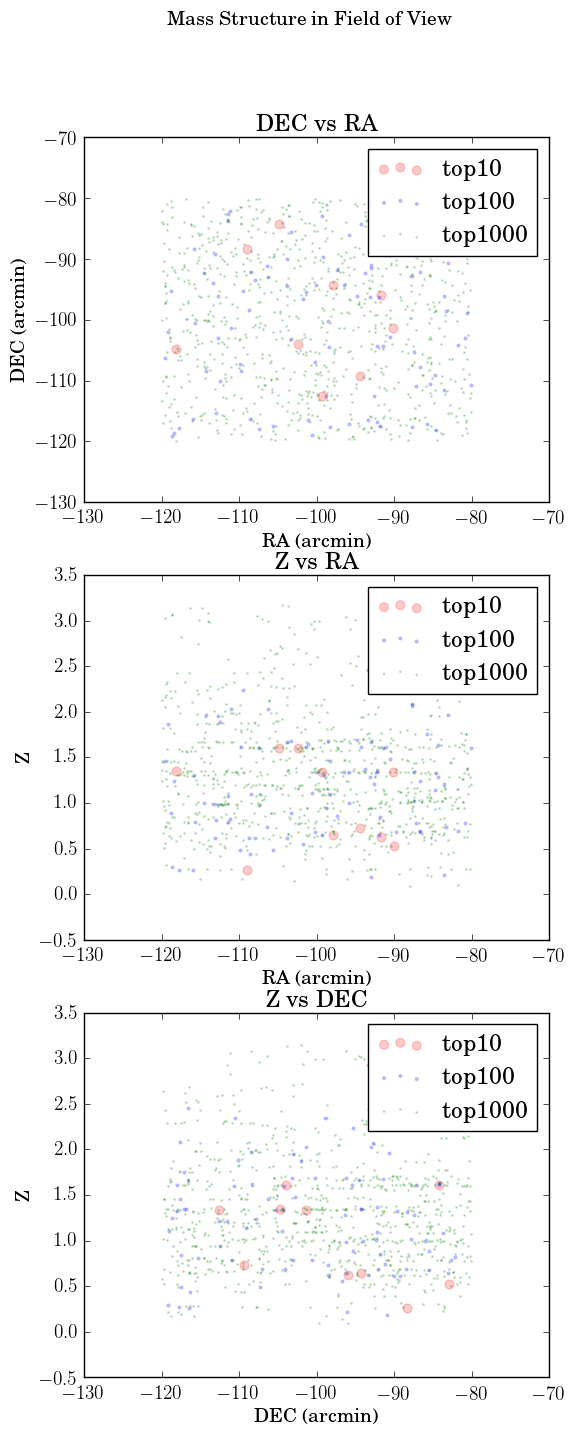

In [154]:
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 6, 16

top10 = fov.sort(ascending=False, inplace=False, columns='mass_h')[:10]
next100 = fov.sort(ascending=False, inplace=False, columns='mass_h')[10:100]
next1000 = fov.sort(ascending=False, inplace=False, columns='mass_h')[100:1000]

dataset = [top10, next100, next1000]
color = ['red', 'blue', 'green']
size = [40,4,1]
label = ['top10','top100','top1000']

ax = plt.subplot(3,1,1)
for i in range(3):
    plt.scatter(x=dataset[i]['ra'],
                y=dataset[i]['dec'], 
                alpha=0.2, 
                color=color[i],
                s=size[i]
               )
plt.title('DEC vs RA')
plt.xlabel('RA (arcmin)')
plt.ylabel('DEC (arcmin)')
plt.legend(['top10','top100','top1000'])

plt.subplot(3,1,2)
for i in range(3):
    plt.scatter(x=dataset[i]['ra'],
                y=dataset[i]['z'], 
                alpha=0.2, 
                color=color[i],
                s=size[i]
               )
plt.title('Z vs RA')
plt.xlabel('RA (arcmin)')
plt.ylabel('Z')
plt.legend(['top10','top100','top1000'])

plt.subplot(3,1,3)
for i in range(3):
    plt.scatter(x=dataset[i]['dec'],
                y=dataset[i]['z'], 
                alpha=0.2, 
                color=color[i],
                s=size[i]
               )
plt.title('Z vs DEC')
plt.xlabel('DEC (arcmin)')
plt.ylabel('Z')
plt.legend(['top10','top100','top1000'])

plt.gcf().suptitle('Mass Structure in Field of View')

In [84]:
sum(guo['mass_h'] > 1e13)

694

In [ ]:
def luminosity(mass):
    """
    Luminosity function and parameters from Vale-Ostriker 2004.
    """
    A = 5.7e9
    m_prime = 1e11
    b = 4
    c = 0.57
    d = 3.72
    k = 0.23
    return (A * (mass / m_prime) ** b) / ((c + (mass / m_prime) ** (d * k)) ** (1 / k))

guo['lum_true'] = luminosity(guo['mass_h'])